# FinTech Space 巴菲特選股策略範例

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取巴菲特選股策略所需之財務面日資料，將資料進行清洗與篩選後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

巴菲特 4 大選股條件如下：
1. 最近年度股東權益報酬率 ＞ 平均值 (市場及產業)
2. 3 年平均股東權益報酬率 ＞ 15%
3. 最近年度毛利率 ＞ 產業平均值
4. ( 最近年度自由現金流量 / 3 年前自由現金流量 ) - 1 > 1

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
由於巴菲特的投資法則希望標的上市時間大於一定的年限，因此我們選取 2019 年底已上市的公司。  
另外，因為 ROE 可以藉由舉債來提升，因此我們排除金融產業這類高槓桿的產業。

p.s. 關於 `get_universe()` 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2019-12-31', 
                    end = '2019-12-31',  # 選取 2019 年年底已上市的股票
                    mkt_bd_e = 'TSE',  # 已上市之股票
                    stktp_e = 'Common Stock',  # 普通股 
                    main_ind_e = 'General Industry') # general industry 篩掉金融產業
pool

Currently used TEJ API key call quota 237/100000 (0.24%)
Currently used TEJ API key data quota 4646663/10000000 (46.47%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 

In [3]:
len(pool)

831

## 利用 TejToolAPI 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 5 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 營運產生現金流量
5. 投資產生現金流量

註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [4]:
import TejToolAPI

start_time = pd.Timestamp('2019-12-31')
end_time = pd.Timestamp('2022-12-30')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '營業毛利率', '營運產生現金流量', '投資產生現金流量'],
                                   transfer_to_chinese = True)

data['自由現金流量'] = data['營運產生現金流量_A'] + data['投資產生現金流量_A']  # 計算自由現金流量 = 營運產生現金流量 + (-)投資產生現金流量
data.drop(columns = ['營運產生現金流量_A', '投資產生現金流量_A'], inplace = True)  # 移除欄位

data

Currently used TEJ API key call quota 306/100000 (0.31%)
Currently used TEJ API key data quota 5975445/10000000 (59.75%)


,股票代碼,日期,主產業別_中文,常續ROE_A,營業毛利率_A,自由現金流量
0,1101,2019-12-31,M1100 水泥工業,8.75,29.16,6913038.0
1,1101,2020-01-02,M1100 水泥工業,8.75,29.16,6913038.0
2,1101,2020-01-03,M1100 水泥工業,8.75,29.16,6913038.0
3,1101,2020-01-06,M1100 水泥工業,8.75,29.16,6913038.0
4,1101,2020-01-07,M1100 水泥工業,8.75,29.16,6913038.0
...,...,...,...,...,...,...
606182,9958,2022-12-26,M2000 鋼鐵工業,4.35,10.79,-686003.0
606183,9958,2022-12-27,M2000 鋼鐵工業,4.35,10.79,-686003.0
606184,9958,2022-12-28,M2000 鋼鐵工業,4.35,10.79,-686003.0
606185,9958,2022-12-29,M2000 鋼鐵工業,4.35,10.79,-686003.0


## 選股條件 1：最近年度股東權益報酬率＞平均值(市場及產業)

In [5]:
# 取出最近年度(2022-12-30)的資料
data_last_1Y = data[data['日期'] == '2022-12-30'].reset_index(drop = True)  

# 取出股票基本資料與 ROE 資料方便觀察
ROE_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A
0,1101,2022-12-30,M1100 水泥工業,-0.07
1,1102,2022-12-30,M1100 水泥工業,5.60
2,1103,2022-12-30,M1100 水泥工業,-1.32
3,1104,2022-12-30,M1100 水泥工業,5.10
4,1108,2022-12-30,M1100 水泥工業,6.30
...,...,...,...,...
810,9944,2022-12-30,M9900 其他,1.94
811,9945,2022-12-30,M9900 其他,22.26
812,9946,2022-12-30,M2500 建材營造,1.51
813,9955,2022-12-30,M9900 其他,-5.44


In [6]:
# 依不同產業分類，計算出產業平均 ROE
industry_ROE_ave = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean')

# 加入 '產業平均ROE' 欄位
ROE_1Y_data['產業平均ROE'] = industry_ROE_ave
 
ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2022-12-30,M1100 水泥工業,-0.07,2.777143
1,1102,2022-12-30,M1100 水泥工業,5.60,2.777143
2,1103,2022-12-30,M1100 水泥工業,-1.32,2.777143
3,1104,2022-12-30,M1100 水泥工業,5.10,2.777143
4,1108,2022-12-30,M1100 水泥工業,6.30,2.777143
...,...,...,...,...,...
810,9944,2022-12-30,M9900 其他,1.94,8.678000
811,9945,2022-12-30,M9900 其他,22.26,8.678000
812,9946,2022-12-30,M2500 建材營造,1.51,6.178400
813,9955,2022-12-30,M9900 其他,-5.44,8.678000


In [7]:
set_1 = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼'])  # 篩選符合選股條件的公司
set_1

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1215',
 '1216',
 '1218',
 '1219',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1301',
 '1303',
 '1307',
 '1308',
 '1309',
 '1315',
 '1319',
 '1323',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1435',
 '1436',
 '1438',
 '1439',
 '1440',
 '1443',
 '1444',
 '1451',
 '1452',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 '1527',
 '1530',
 '1535',
 '1536',
 '1537',
 '1539',
 '1540',
 '1541',
 '1558',
 '1560',
 '1568',
 '1583',
 '1587',
 '1604',
 '1605',
 '1615',
 '1707',
 '1708',
 '1709',
 '1712',
 '1713',
 '1717',
 '1720',
 '1723',
 '1730',
 '1733',
 '1760',
 '1762',
 '1773',
 '1783',
 '1795',
 '1817',
 '1904',
 '1905',
 '2006',
 '2012',
 '2013',
 '2015',
 '2020',
 '2025',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2062',
 '2103',
 '2105',
 '2106',
 '2108',
 '2109',
 '2114',
 '2206',
 '2227',
 '2228',
 

In [8]:
len(set_1)

397

## 選股條件 2：3年平均股東權益報酬率＞15%

In [9]:
# 取出近三年(2022-12-30, 2021-12-30, 2020-12-30)的資料
data_last_3Y = data[data['日期'].isin(['2022-12-30', '2021-12-30', '2020-12-30'])].reset_index(drop = True)

# 計算公司三年平均的 ROE
ROE_3Y_ave = data_last_3Y.groupby('股票代碼')['常續ROE_A'].mean()

# 從 Series 轉成 Dataframe，並重新命名欄位
ROE_3Y_ave = pd.DataFrame(ROE_3Y_ave).rename(columns = {'常續ROE_A': '3年平均ROE'})

ROE_3Y_ave

,3年平均ROE
股票代碼,
1101,5.280000
1102,6.776667
1103,-2.246667
1104,3.960000
1108,5.650000
...,...
9944,1.683333
9945,14.920000
9946,2.293333


In [10]:
set_2 = set(ROE_3Y_ave[ROE_3Y_ave['3年平均ROE'] > 15].index)  # 篩選符合選股條件的公司
set_2

{'1232',
 '1309',
 '1325',
 '1476',
 '1477',
 '1526',
 '1537',
 '1541',
 '1707',
 '1773',
 '2028',
 '2059',
 '2108',
 '2327',
 '2330',
 '2345',
 '2348',
 '2368',
 '2376',
 '2377',
 '2379',
 '2383',
 '2385',
 '2395',
 '2404',
 '2454',
 '2455',
 '2458',
 '2465',
 '2467',
 '2480',
 '2505',
 '2546',
 '2597',
 '2603',
 '2609',
 '2615',
 '2636',
 '2905',
 '2912',
 '3006',
 '3014',
 '3017',
 '3023',
 '3030',
 '3034',
 '3037',
 '3042',
 '3048',
 '3130',
 '3209',
 '3413',
 '3443',
 '3515',
 '3533',
 '3557',
 '3563',
 '3669',
 '4536',
 '4952',
 '4961',
 '4968',
 '5234',
 '5269',
 '5283',
 '5434',
 '5471',
 '6202',
 '6278',
 '6281',
 '6409',
 '6412',
 '6491',
 '6531',
 '6582',
 '6669',
 '6670',
 '6706',
 '8016',
 '8046',
 '8081',
 '8112',
 '8210',
 '8261',
 '8341',
 '8422',
 '8454',
 '8464',
 '8478',
 '9906',
 '9910',
 '9914',
 '9917',
 '9921'}

In [11]:
len(set_2)

94

## 選股條件 3：最近年度毛利率＞產業平均值

In [12]:
# 取出股票基本資料與 Gross Margin 資料方便觀察
GM_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '營業毛利率_A']]

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A
0,1101,2022-12-30,M1100 水泥工業,5.55
1,1102,2022-12-30,M1100 水泥工業,14.83
2,1103,2022-12-30,M1100 水泥工業,3.44
3,1104,2022-12-30,M1100 水泥工業,18.49
4,1108,2022-12-30,M1100 水泥工業,19.85
...,...,...,...,...
810,9944,2022-12-30,M9900 其他,26.99
811,9945,2022-12-30,M9900 其他,22.23
812,9946,2022-12-30,M2500 建材營造,16.70
813,9955,2022-12-30,M9900 其他,0.01


In [13]:
# 依不同產業分類，計算出產業平均 GM
industry_GM_ave = GM_1Y_data.groupby('主產業別_中文')['營業毛利率_A'].transform('mean')  

# 加入 '產業平均毛利率' 欄位
GM_1Y_data['產業平均毛利率'] = industry_GM_ave

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A,產業平均毛利率
0,1101,2022-12-30,M1100 水泥工業,5.55,12.614286
1,1102,2022-12-30,M1100 水泥工業,14.83,12.614286
2,1103,2022-12-30,M1100 水泥工業,3.44,12.614286
3,1104,2022-12-30,M1100 水泥工業,18.49,12.614286
4,1108,2022-12-30,M1100 水泥工業,19.85,12.614286
...,...,...,...,...,...
810,9944,2022-12-30,M9900 其他,26.99,28.038833
811,9945,2022-12-30,M9900 其他,22.23,28.038833
812,9946,2022-12-30,M2500 建材營造,16.70,27.686800
813,9955,2022-12-30,M9900 其他,0.01,28.038833


In [14]:
set_3 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業平均毛利率']]['股票代碼'])  # 篩選符合選股條件的公司
set_3

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1216',
 '1217',
 '1229',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1307',
 '1308',
 '1315',
 '1319',
 '1323',
 '1324',
 '1339',
 '1402',
 '1409',
 '1410',
 '1414',
 '1416',
 '1417',
 '1419',
 '1432',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1443',
 '1452',
 '1457',
 '1460',
 '1463',
 '1464',
 '1465',
 '1467',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1513',
 '1524',
 '1526',
 '1527',
 '1528',
 '1529',
 '1533',
 '1536',
 '1540',
 '1560',
 '1583',
 '1587',
 '1603',
 '1604',
 '1611',
 '1614',
 '1701',
 '1702',
 '1707',
 '1708',
 '1718',
 '1720',
 '1730',
 '1731',
 '1732',
 '1734',
 '1736',
 '1737',
 '1760',
 '1762',
 '1783',
 '1786',
 '1789',
 '1795',
 '1806',
 '1810',
 '1817',
 '1903',
 '2006',
 '2008',
 '2012',
 '2015',
 '2017',
 '2023',
 '2024',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2107',
 '2108',
 '2114',
 '2201',
 '2228',
 '2231',
 '2233',
 '2302',
 '2303',
 

In [15]:
len(set_3)

372

## 選股條件 4：(最近年度自由現金流量 / 3年前自由現金流量) - 1 > 1

In [16]:
# 取出最近一年及三年前的資料
cash_data = data[data['日期'].isin(['2019-12-31', '2022-12-30'])].reset_index(drop = True)  

# 取出股票基本資料與自由現金流量方便觀察
cash_data = cash_data[['股票代碼', '日期', '自由現金流量']]  

cash_data

,股票代碼,日期,自由現金流量
0,1101,2019-12-31,6913038.0
1,1101,2022-12-30,-7925014.0
2,1102,2019-12-31,12923175.0
3,1102,2022-12-30,13823534.0
4,1103,2019-12-31,-23049.0
...,...,...,...
1641,9946,2022-12-30,554326.0
1642,9955,2019-12-31,296341.0
1643,9955,2022-12-30,-28051.0
1644,9958,2019-12-31,759874.0


In [17]:
# 計算自由現金流量比率： 最近年度自由現金流量 / 3年前自由現金流量
cash_data['自由現金流量比率'] = cash_data['自由現金流量'] / cash_data.groupby('股票代碼')['自由現金流量'].shift(1)

# 計算'指標'： 自由現金流量比率 - 1
cash_data['指標'] = cash_data['自由現金流量比率'] - 1

cash_data

,股票代碼,日期,自由現金流量,自由現金流量比率,指標
0,1101,2019-12-31,6913038.0,NaN,NaN
1,1101,2022-12-30,-7925014.0,-1.146387,-2.146387
2,1102,2019-12-31,12923175.0,NaN,NaN
3,1102,2022-12-30,13823534.0,1.069670,0.069670
4,1103,2019-12-31,-23049.0,NaN,NaN
...,...,...,...,...,...
1641,9946,2022-12-30,554326.0,0.205434,-0.794566
1642,9955,2019-12-31,296341.0,NaN,NaN
1643,9955,2022-12-30,-28051.0,-0.094658,-1.094658
1644,9958,2019-12-31,759874.0,NaN,NaN


In [18]:
set_4 = set(cash_data[cash_data['指標'] > 1]['股票代碼'])  # 篩選符合選股條件的公司
set_4

{'1104',
 '1219',
 '1235',
 '1236',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1423',
 '1438',
 '1442',
 '1452',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1473',
 '1477',
 '1522',
 '1539',
 '1541',
 '1609',
 '1616',
 '1707',
 '1723',
 '1727',
 '1731',
 '1736',
 '1737',
 '1783',
 '1805',
 '1909',
 '2010',
 '2017',
 '2034',
 '2069',
 '2101',
 '2104',
 '2114',
 '2302',
 '2303',
 '2330',
 '2331',
 '2338',
 '2344',
 '2345',
 '2348',
 '2351',
 '2358',
 '2368',
 '2369',
 '2387',
 '2392',
 '2393',
 '2399',
 '2401',
 '2404',
 '2414',
 '2415',
 '2417',
 '2428',
 '2429',
 '2438',
 '2439',
 '2440',
 '2454',
 '2457',
 '2458',
 '2462',
 '2464',
 '2465',
 '2467',
 '2471',
 '2476',
 '2482',
 '2484',
 '2488',
 '2497',
 '2509',
 '2530',
 '2535',
 '2540',
 '2543',
 '2545',
 '2603',
 '2607',
 '2608',
 '2609',
 '2612',
 '2613',
 '2615',
 '2616',
 '2617',
 '2618',
 '2633',
 '2636',
 '2704',
 '2910',
 '3003',
 '3008',
 '3013',
 '3015',
 '3017',
 '3027',
 '3035',
 '3040',
 '3051',
 '3052',
 '3094',
 

In [19]:
len(set_4)

186

## 取出符合所有條件的股票

In [20]:
tickers = list(set_1 & set_2 & set_3 & set_4)
tickers

['1477',
 '2458',
 '2467',
 '2454',
 '8261',
 '3557',
 '2330',
 '2368',
 '3563',
 '6531',
 '6202',
 '4961',
 '5283',
 '2615',
 '2609',
 '2603',
 '2348',
 '5471',
 '1707']

In [21]:
len(tickers)

19

In [22]:
import tejapi

tejapi.ApiConfig.api_key = tej_key
tejapi.ApiConfig.ignoretz = api_base

ticker_data = tejapi.get('TWN/APISTOCK',  # 證券屬性資料表
                  coid = tickers,
                  opts = {'columns':['coid', 'stk_name', 'tseindnm_c']},
                  chinese_column_name = True,
                  paginate = True)

ticker_data

,公司簡稱,證券名稱,交易所產業名稱
None,,,
0,1477,聚陽,紡織纖維
1,1707,葡萄王,生技醫療
2,2330,台積電,半導體業
3,2348,海悅,其他
4,2368,金像電,電子零組件業
5,2454,聯發科,半導體業
6,2458,義隆,半導體業
7,2467,志聖,電子零組件業
8,2603,長榮,航運業


## 整合每間公司符合哪些選股條件

In [23]:
company_list = data['股票代碼'].unique().tolist()
coid = {'公司代碼': company_list}

data_combine = pd.DataFrame(coid)
data_combine['選股條件 1'] = data_combine['公司代碼'].isin(set_1)
data_combine['選股條件 2'] = data_combine['公司代碼'].isin(set_2)
data_combine['選股條件 3'] = data_combine['公司代碼'].isin(set_3)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['符合條件數量'] = data_combine.iloc[:, 1:5].sum(axis = 1)

data_combine

,公司代碼,選股條件 1,選股條件 2,選股條件 3,選股條件 4,符合條件數量
0,1101,False,False,False,False,0
1,1102,True,False,True,False,2
2,1103,False,False,False,False,0
3,1104,True,False,True,True,3
4,1108,True,False,True,False,2
...,...,...,...,...,...,...
826,9944,False,False,False,True,1
827,9945,True,False,False,False,1
828,9946,False,False,False,False,0
829,9955,False,False,False,False,0


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tqant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [24]:
start = '2023-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 313/100000 (0.31%)
Currently used TEJ API key data quota 6189373/10000000 (61.89%)


[2024-02-23 02:19:16.405494] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-23 02:19:17.954516] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  
舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [25]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。 

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [26]:
def handle_data(context, data):

    # 回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))

    context.day += 1  # 以免重複買進

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [27]:
import matplotlib.pyplot as plt

capital_base = 1e7  # 設定初始資金

def analyze(context, results):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

### Run_algorithm 函式

進行策略回測。

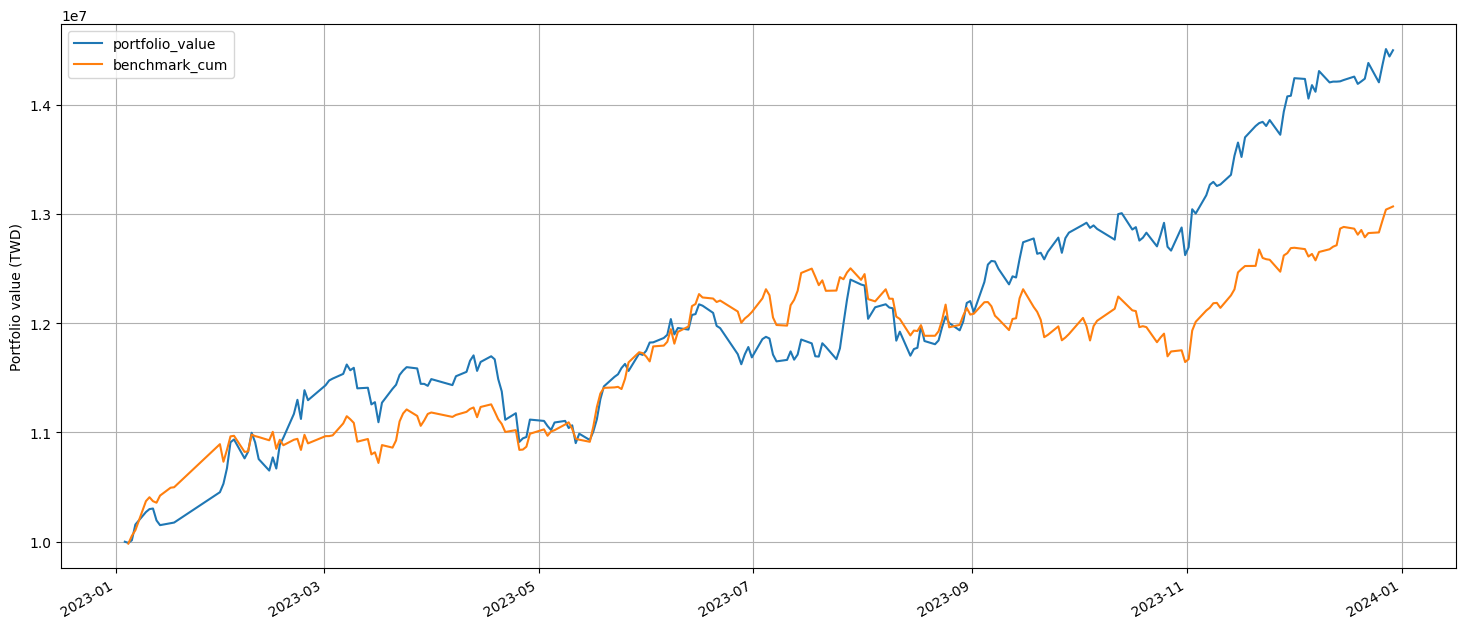

,period_open,period_close,net_leverage,gross_leverage,ending_value,short_value,pnl,ending_cash,treasury_return,portfolio_value,...,beta,algo_volatility,sortino,trading_days,algorithm_period_return,sharpe,benchmark_period_return,excess_return,benchmark_volatility,benchmark_cum
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,0.000000,0.000000,0.00,0.0,0.000000,1.000000e+07,0.0,1.000000e+07,...,NaN,NaN,NaN,1,0.000000,NaN,0.000000,0.000000,NaN,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,0.769797,0.769797,7689469.70,0.0,-11043.482469,2.299487e+06,0.0,9.988957e+06,...,NaN,0.012396,-11.224972,2,-0.001104,-11.224972,-0.001741,0.000637,NaN,9.982590e+06
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,0.850827,0.850827,8519644.50,0.0,24409.426630,1.493721e+06,0.0,1.001337e+07,...,0.397804,0.028822,11.114993,3,0.001337,3.903246,0.005424,-0.004088,0.100115,1.005424e+07
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,0.876594,0.876594,8903680.00,0.0,143760.005469,1.253446e+06,0.0,1.015713e+07,...,0.855513,0.112890,112.812210,4,0.015713,8.759424,0.010506,0.005206,0.073959,1.010506e+07
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,0.906446,0.906446,9310579.05,0.0,114394.553642,9.609415e+05,0.0,1.027152e+07,...,0.322769,0.110781,173.303169,5,0.027152,12.264888,0.037143,-0.009991,0.191248,1.037143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,0.943948,0.943948,13408166.20,0.0,-177254.100000,7.961768e+05,0.0,1.420434e+07,...,0.854921,0.153741,3.929892,235,0.420434,2.526306,0.283076,0.137359,0.126110,1.283076e+07
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,0.944561,0.944561,13565255.70,0.0,157089.500000,7.961768e+05,0.0,1.436143e+07,...,0.856542,0.153728,4.041298,236,0.436143,2.592624,0.293786,0.142357,0.126064,1.293786e+07
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,0.945124,0.945124,13712566.20,0.0,147310.500000,7.961768e+05,0.0,1.450874e+07,...,0.857854,0.153663,4.143587,237,0.450874,2.653761,0.303973,0.146901,0.125989,1.303973e+07
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,0.944866,0.944866,13644625.50,0.0,-67940.700000,7.961768e+05,0.0,1.444080e+07,...,0.857897,0.153475,4.079478,238,0.444080,2.613533,0.305349,0.138732,0.125721,1.305349e+07


In [28]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

results

<AxesSubplot:>

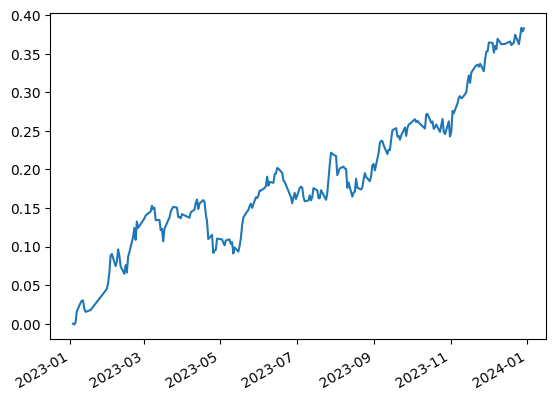

In [29]:
results.returns.cumsum().plot()  # 繪製累積回報圖

### 查看 positions, transactions & orders 資料表

In [30]:
# 取出 results 中的 positions, transactions & orders 資料表
positions, transactions, orders = get_transaction_detail(results)   

In [31]:
positions

,sid,symbol,asset,amount,cost_basis,last_sale_price
2023-01-04 13:30:00+08:00,0,1477,Equity(0 [1477]),2333,224.820218,224.5
2023-01-04 13:30:00+08:00,6,2458,Equity(6 [2458]),6049,86.925201,86.8
2023-01-04 13:30:00+08:00,7,2467,Equity(7 [2467]),1350,43.364928,43.3
2023-01-04 13:30:00+08:00,5,2454,Equity(5 [2454]),817,636.906981,636.0
2023-01-04 13:30:00+08:00,18,8261,Equity(18 [8261]),5036,105.149816,105.0
...,...,...,...,...,...,...
2023-12-29 13:30:00+08:00,9,2609,Equity(9 [2609]),8147,63.590586,51.3
2023-12-29 13:30:00+08:00,8,2603,Equity(8 [2603]),3289,156.222560,143.5
2023-12-29 13:30:00+08:00,3,2348,Equity(3 [2348]),8262,64.769661,93.2
2023-12-29 13:30:00+08:00,15,5471,Equity(15 [5471]),10422,50.665757,57.4


In [32]:
transactions

,sid,symbol,amount,dt,price,order_id,asset,commission
2023-01-04 13:30:00+08:00,0,1477,2333,2023-01-04 13:30:00+08:00,224.500029,b556f204afa047d081980bf496c88489,Equity(0 [1477]),None
2023-01-04 13:30:00+08:00,6,2458,6049,2023-01-04 13:30:00+08:00,86.801378,7722961d2c2b4c3587f04e11b46e4ee3,Equity(6 [2458]),None
2023-01-04 13:30:00+08:00,7,2467,1350,2023-01-04 13:30:00+08:00,43.302706,63bc890a3f214158a118254fe9f652b4,Equity(7 [2467]),None
2023-01-04 13:30:00+08:00,5,2454,817,2023-01-04 13:30:00+08:00,636.000004,ad8682262e4c40aa859cb0061ce52435,Equity(5 [2454]),None
2023-01-04 13:30:00+08:00,18,8261,5036,2023-01-04 13:30:00+08:00,105.000094,97e101306e5d4f53a98a239ca508e77f,Equity(18 [8261]),None
2023-01-04 13:30:00+08:00,11,3557,800,2023-01-04 13:30:00+08:00,49.203075,164ebed5d5994ae4870e212d9fbe61d2,Equity(11 [3557]),None
2023-01-04 13:30:00+08:00,2,2330,1161,2023-01-04 13:30:00+08:00,449.500000,11ff1bf2526746a5af677e4ff2426c6c,Equity(2 [2330]),None
2023-01-04 13:30:00+08:00,4,2368,5900,2023-01-04 13:30:00+08:00,87.000004,cde8c1fa416a4624a21fc4e34fa720f8,Equity(4 [2368]),None
2023-01-04 13:30:00+08:00,12,3563,1050,2023-01-04 13:30:00+08:00,131.008187,8c96f4185a4f4f2ca64598058d5d7e9b,Equity(12 [3563]),None
2023-01-04 13:30:00+08:00,17,6531,3024,2023-01-04 13:30:00+08:00,176.000059,70272d99174e4691b1d5913724690741,Equity(17 [6531]),None


In [33]:
orders

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,0,1477,b556f204afa047d081980bf496c88489,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,2333,0,0.0,None,None,False,False,Equity(0 [1477]),0
2023-01-03 13:30:00+08:00,6,2458,7722961d2c2b4c3587f04e11b46e4ee3,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,6049,0,0.0,None,None,False,False,Equity(6 [2458]),0
2023-01-03 13:30:00+08:00,7,2467,63bc890a3f214158a118254fe9f652b4,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,12155,0,0.0,None,None,False,False,Equity(7 [2467]),0
2023-01-03 13:30:00+08:00,5,2454,ad8682262e4c40aa859cb0061ce52435,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,817,0,0.0,None,None,False,False,Equity(5 [2454]),0
2023-01-03 13:30:00+08:00,18,8261,97e101306e5d4f53a98a239ca508e77f,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,5036,0,0.0,None,None,False,False,Equity(18 [8261]),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-12 13:30:00+08:00,3,2348,6fea6f30b7c344f7bd7d6ad5e027b85b,2023-01-12 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,8262,7425,688.0,None,None,False,False,Equity(3 [2348]),0
2023-01-13 13:30:00+08:00,7,2467,63bc890a3f214158a118254fe9f652b4,2023-01-13 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,12155,11625,728.0,None,None,False,False,Equity(7 [2467]),0
2023-01-13 13:30:00+08:00,3,2348,6fea6f30b7c344f7bd7d6ad5e027b85b,2023-01-13 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,8262,8125,753.0,None,None,False,False,Equity(3 [2348]),0
2023-01-16 13:30:00+08:00,7,2467,63bc890a3f214158a118254fe9f652b4,2023-01-16 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,12155,12155,761.0,None,None,False,False,Equity(7 [2467]),1


In [34]:
orders[orders['symbol'] == '3557']

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,0,0.0,None,None,False,False,Equity(11 [3557]),0
2023-01-04 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,800,57.0,None,None,False,False,Equity(11 [3557]),0
2023-01-05 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-05 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,1450,103.0,None,None,False,False,Equity(11 [3557]),0
2023-01-06 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-06 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,1675,123.0,None,None,False,False,Equity(11 [3557]),0
2023-01-09 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-09 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,2225,162.0,None,None,False,False,Equity(11 [3557]),0
2023-01-10 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-10 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,10708,797.0,None,None,False,False,Equity(11 [3557]),1


In [35]:
orders.loc['2023-01-03']

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,0,1477,b556f204afa047d081980bf496c88489,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,2333,0,0.0,None,None,False,False,Equity(0 [1477]),0
2023-01-03 13:30:00+08:00,6,2458,7722961d2c2b4c3587f04e11b46e4ee3,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,6049,0,0.0,None,None,False,False,Equity(6 [2458]),0
2023-01-03 13:30:00+08:00,7,2467,63bc890a3f214158a118254fe9f652b4,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,12155,0,0.0,None,None,False,False,Equity(7 [2467]),0
2023-01-03 13:30:00+08:00,5,2454,ad8682262e4c40aa859cb0061ce52435,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,817,0,0.0,None,None,False,False,Equity(5 [2454]),0
2023-01-03 13:30:00+08:00,18,8261,97e101306e5d4f53a98a239ca508e77f,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,5036,0,0.0,None,None,False,False,Equity(18 [8261]),0
2023-01-03 13:30:00+08:00,11,3557,164ebed5d5994ae4870e212d9fbe61d2,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,10708,0,0.0,None,None,False,False,Equity(11 [3557]),0
2023-01-03 13:30:00+08:00,2,2330,11ff1bf2526746a5af677e4ff2426c6c,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,1161,0,0.0,None,None,False,False,Equity(2 [2330]),0
2023-01-03 13:30:00+08:00,4,2368,cde8c1fa416a4624a21fc4e34fa720f8,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,5900,0,0.0,None,None,False,False,Equity(4 [2368]),0
2023-01-03 13:30:00+08:00,12,3563,8c96f4185a4f4f2ca64598058d5d7e9b,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,4002,0,0.0,None,None,False,False,Equity(12 [3563]),0
2023-01-03 13:30:00+08:00,17,6531,70272d99174e4691b1d5913724690741,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,3024,0,0.0,None,None,False,False,Equity(17 [6531]),0


## Pyfolio

Pyfolio 與 zipline 的回測結果兼容，讓我們輕鬆用幾行程式碼，就能產出我們需要的投資風險及績效圖表。

p.s. 詳細 Pyfolio 使用方法可參考： TQuant Lab github：[Pyfolio](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Pyfolio.ipynb)

In [36]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

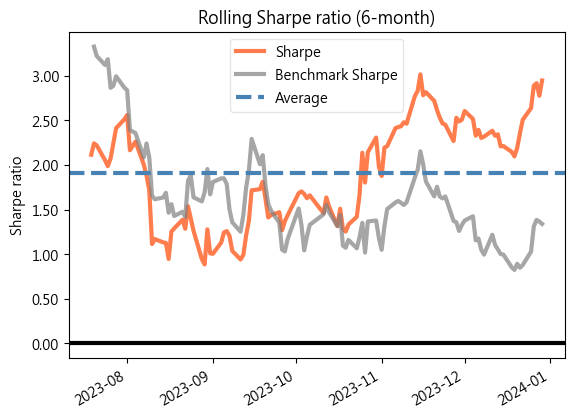

In [37]:
# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,47.939%
Cumulative returns,44.98%
Annual volatility,15.317%
Sharpe ratio,2.64
Calmar ratio,6.99
Stability,0.88
Max drawdown,-6.862%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.86,2023-04-12,2023-05-11,2023-05-29,33
1,5.62,2023-07-28,2023-08-14,2023-09-05,27
2,4.55,2023-03-07,2023-03-16,2023-04-11,23
3,4.51,2023-06-15,2023-06-27,2023-07-27,29
4,3.15,2023-02-08,2023-02-13,2023-02-20,9


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.16%,-2.47%,2.73%


Top 10 long positions of all time,max
sid,
2368,10.59%
6531,10.12%
3563,8.32%
1477,7.03%
2458,6.99%
4961,6.93%
3557,6.80%
2330,6.03%
2454,5.86%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2368,10.59%
6531,10.12%
3563,8.32%
1477,7.03%
2458,6.99%
4961,6.93%
3557,6.80%
2330,6.03%
2454,5.86%


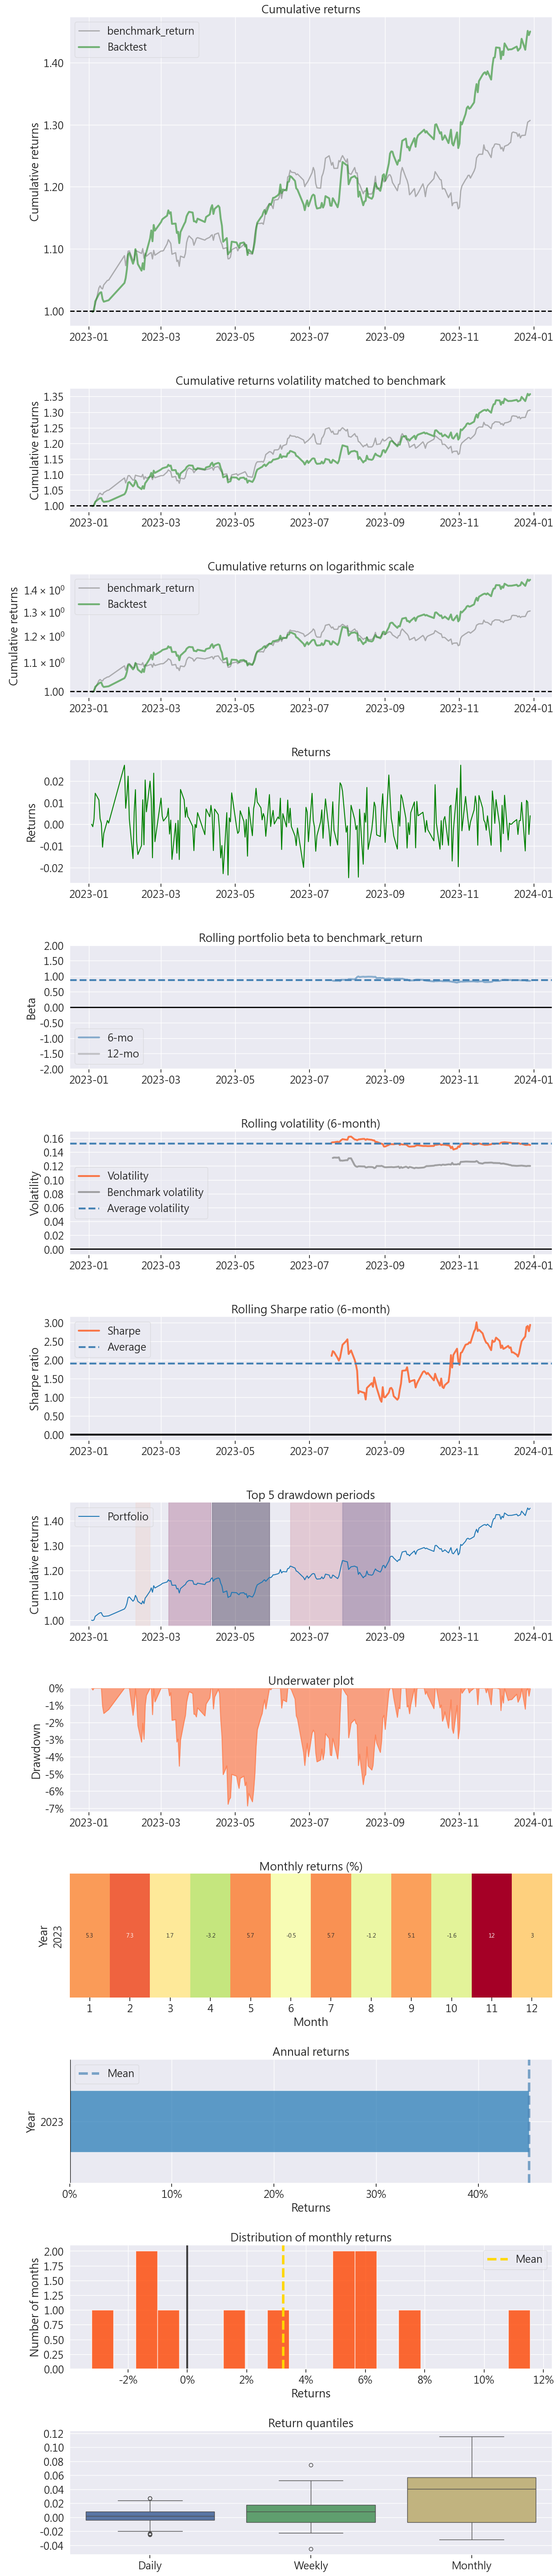

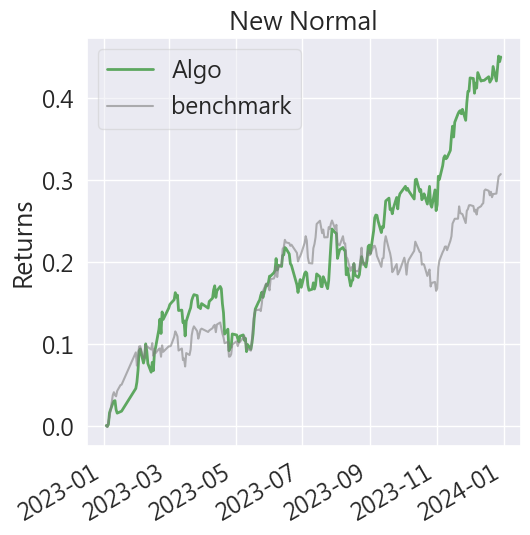

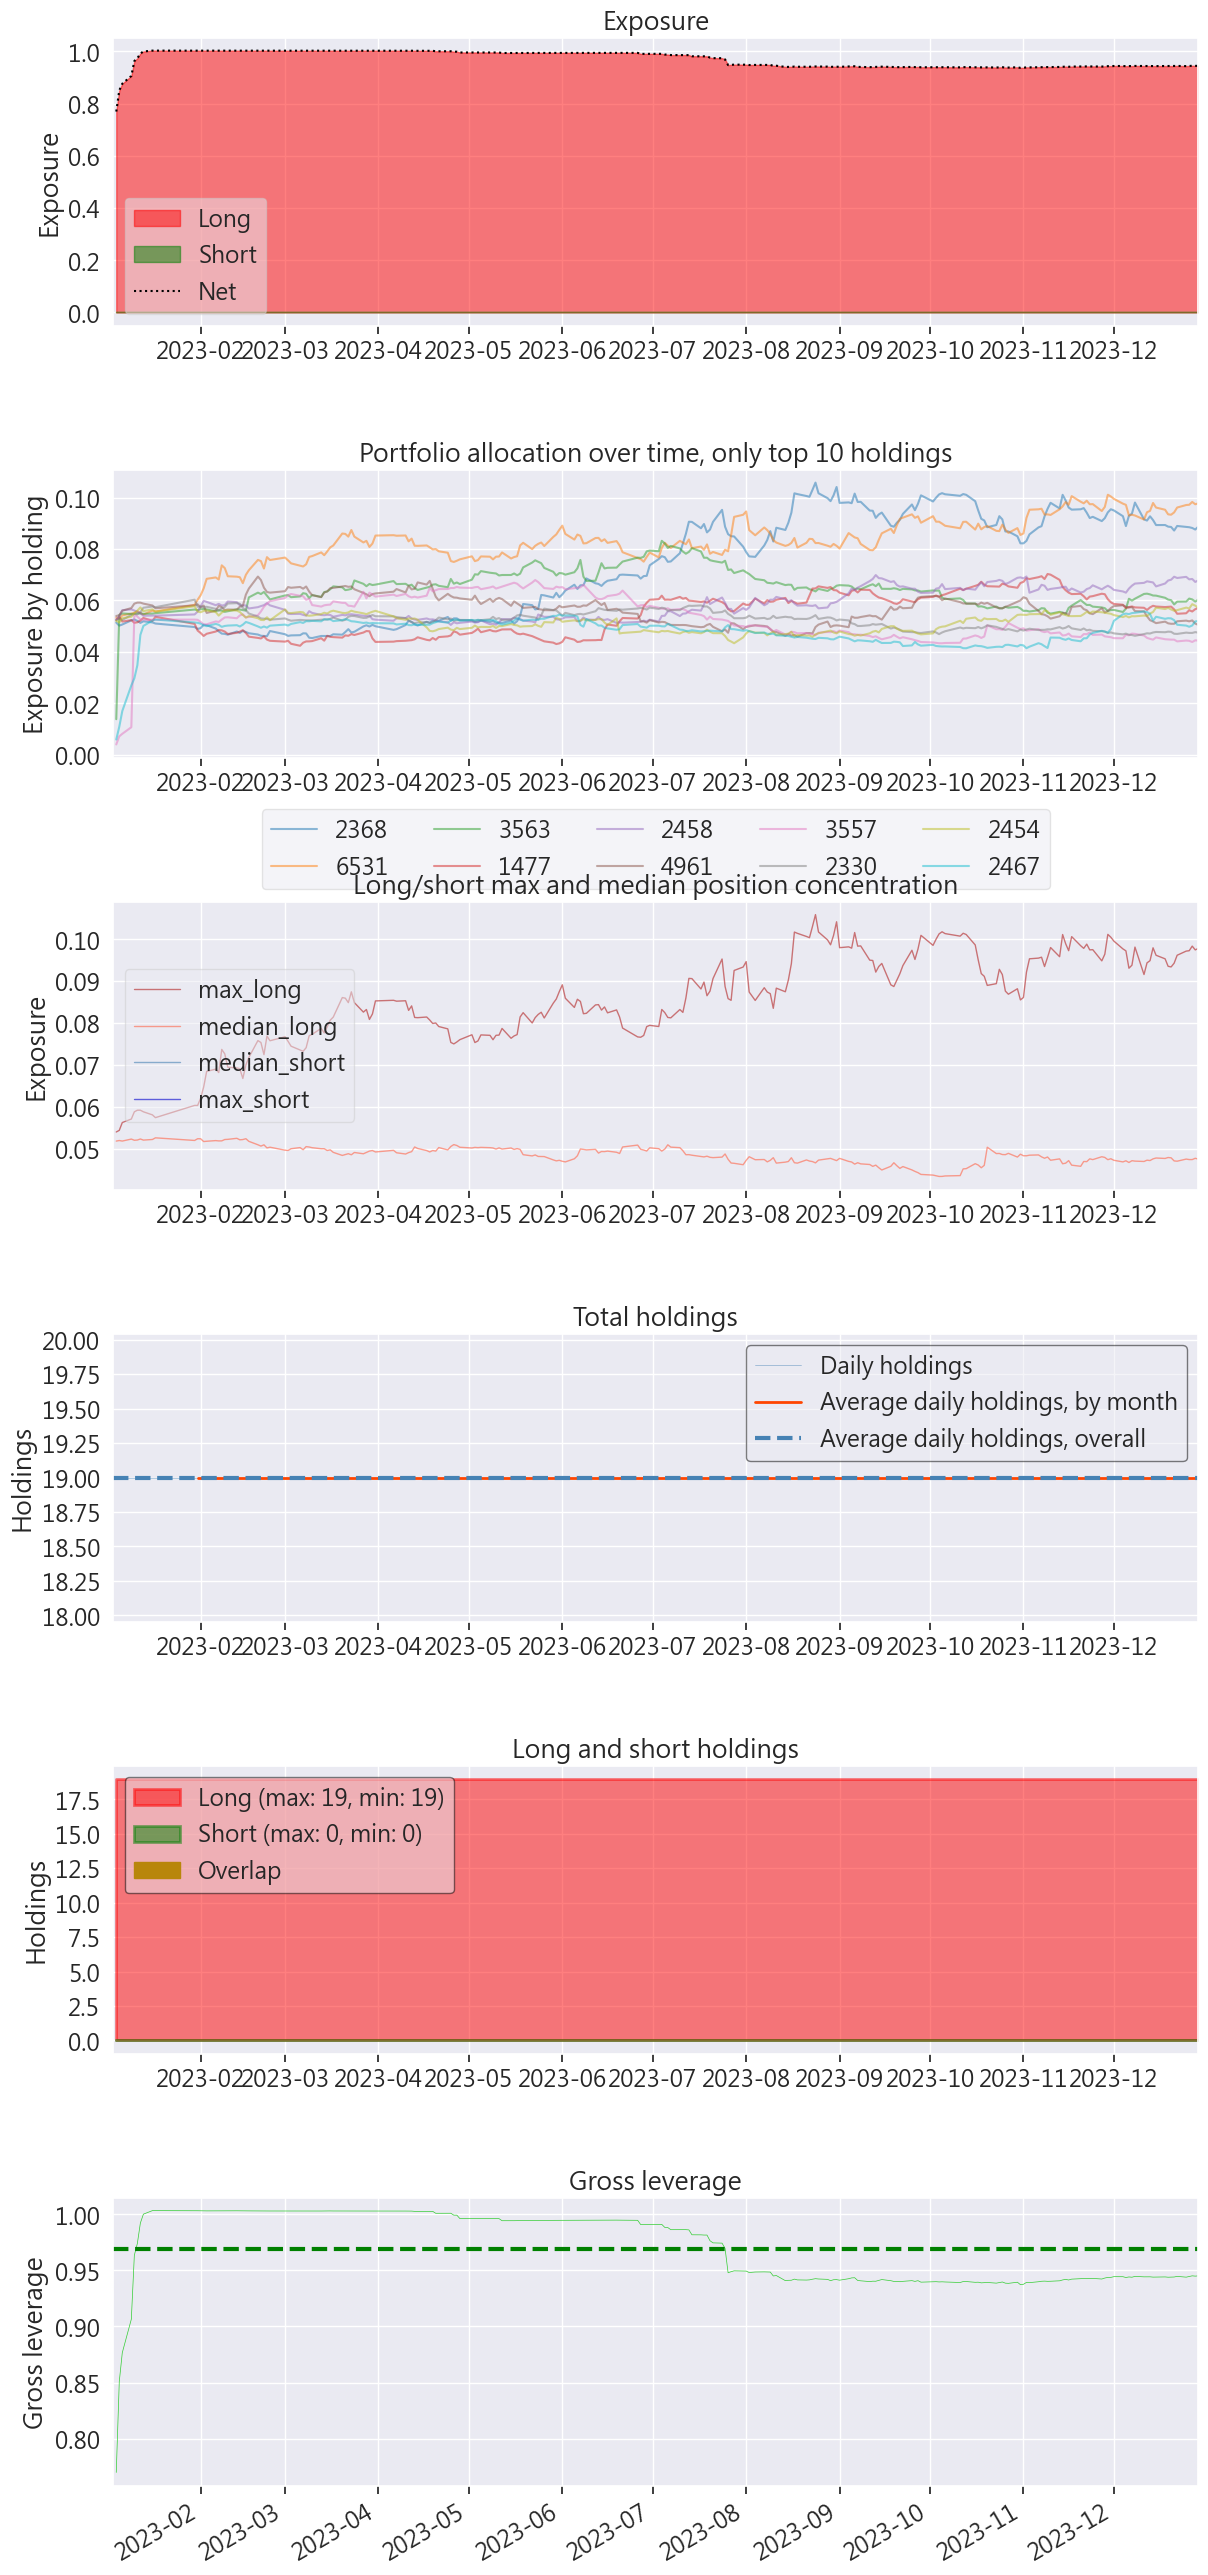

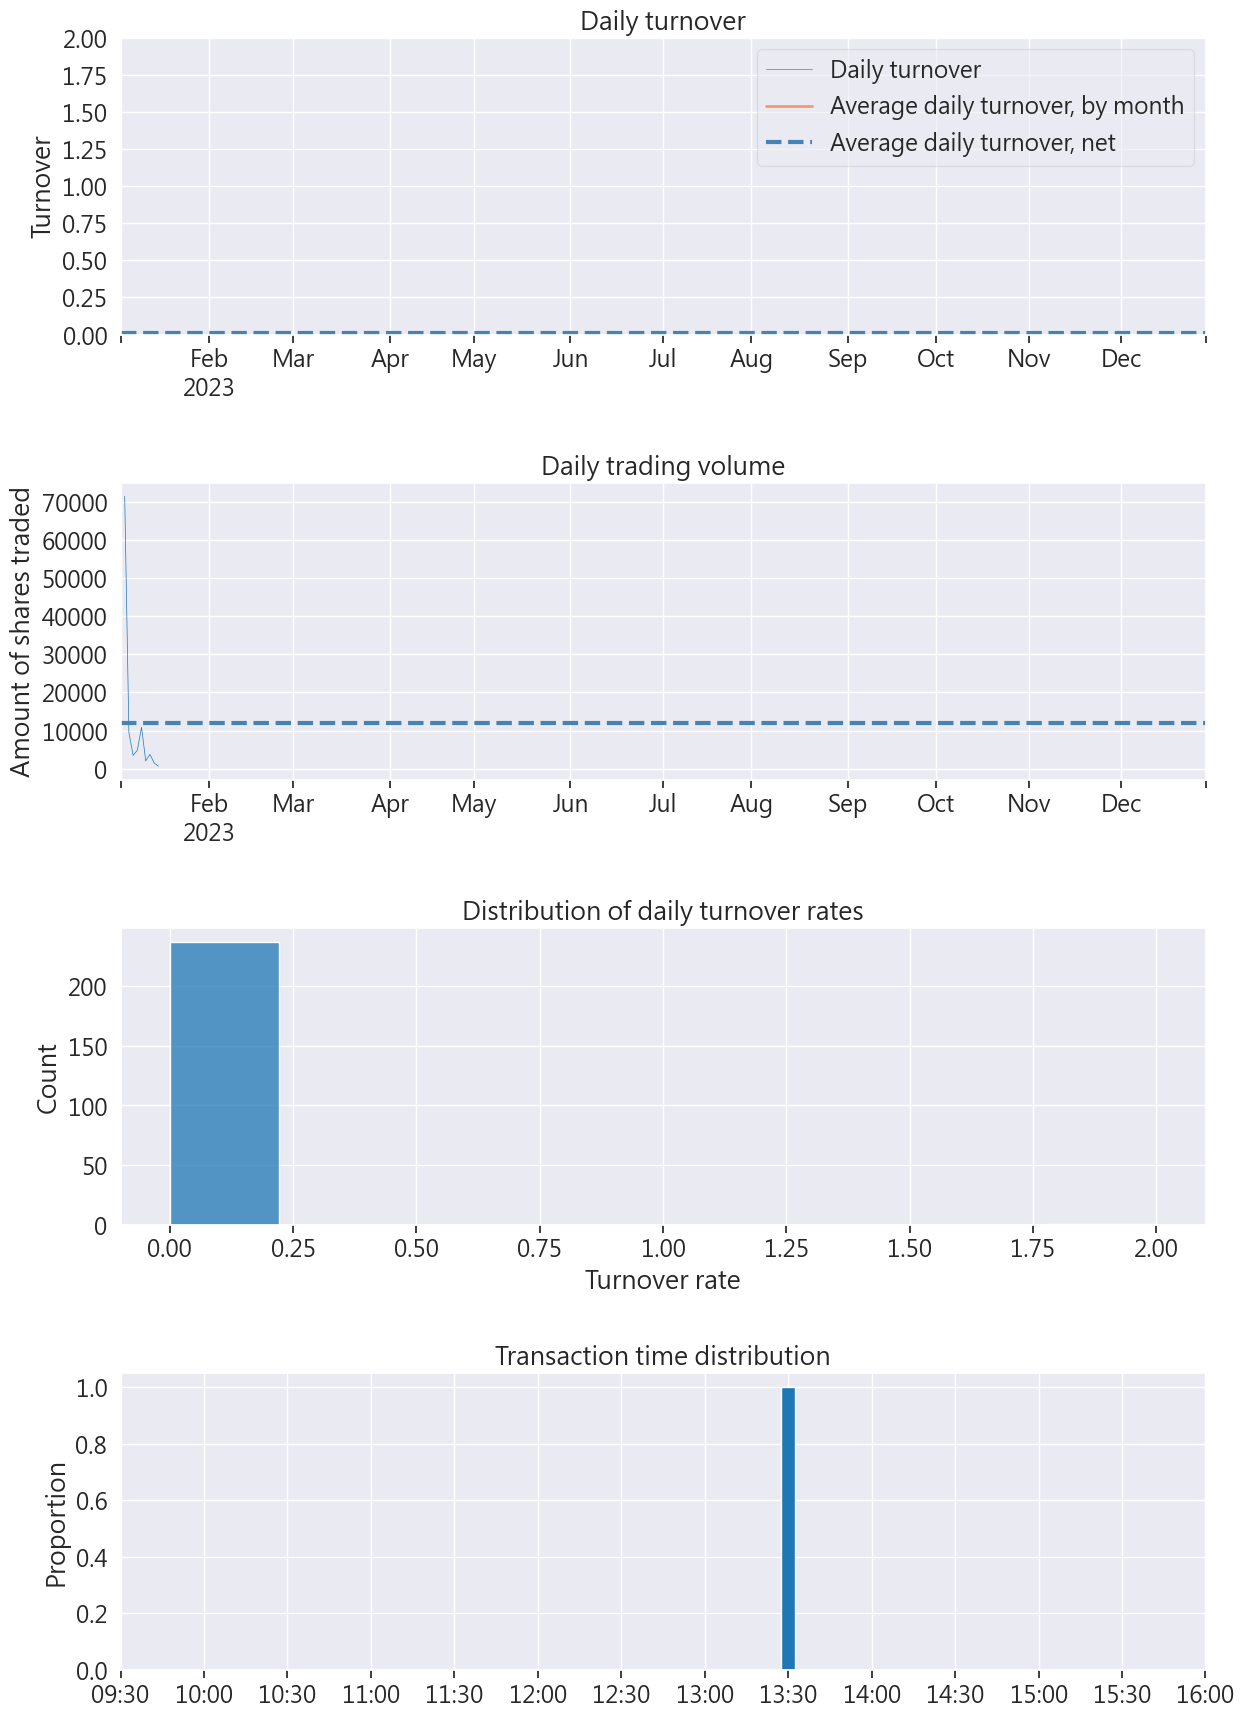

In [38]:
# 繪製 Pyfolio 中提供的所有圖表

pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )